In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Load data

In [ ]:
data = pd.read_csv("./deucalion_times.csv")# deucalion data
figname='deucalion.pdf'

#data = pd.read_csv("./Finisterrae_times.csv")# Finisterrae 3 data
#figname='finisterrae.pdf'


# Set to True to split the times into transpose/reshape and kernel time in the graphs
split_times=False

In [204]:
# Get the three series, dense, venom and venom with no transposition
if "mean" in data.columns:
    #Data from deucalion file using time_it repeat
    time_column = "mean"
    gpus = 4
elif "total_milliseconds" in data.columns:
    # Data from manual timekeeping to keeps track of time used in transpose/reshape 
    gpus = 2
    time_column = "total_milliseconds"
    # Generate transpose and reshape times from the csv data
    # Create a new column with the value of the milliseconds_excluding_transpose column subtracted from the second to total_milliseconds column
    data['transpose_time'] = data['total_milliseconds'] - data['milliseconds_excluding_transpose']
    # Handle missing values for the 'milliseconds_excluding_transpose' column
    data['transpose_time'] = data['transpose_time'].fillna(data['total_milliseconds'])


# Convert to seconds for smaller numbers
data[time_column] = data[time_column] / 1000
if "total_milliseconds" in data.columns:
    data['milliseconds_excluding_transpose'] = data['milliseconds_excluding_transpose'] / 1000
    data['transpose_time'] = data['transpose_time'] / 1000




dense_grouped = data[data['name'] == 'dense'].groupby(['bs'])
# Autodetect amount of gpus or entries for each configuration.
# Count the number of rows in the first group
gpus = dense_grouped.get_group(list(dense_grouped.groups.keys())[0]).shape[0]
print('Detected', gpus, 'entries for dense times, setting amount of gpus to that number')

dense = data[data['name'] == 'dense'].groupby(['bs'])[time_column].mean().reset_index(name="step_time_mean")

# Comment if branch to not split bars into kernel and transpose/reshape times
if 'transpose_time' in data and split_times:
    # Use time with no tranpose as main time and then stack transpose time on top.
    venom_kernel_time = data[data['name'] == 'venom'].groupby(['bs'])['milliseconds_excluding_transpose'].mean().reset_index(name="step_time_mean")
    venom_transpose_time = data[data['name'] == 'venom'].groupby(['bs'])['transpose_time'].mean().reset_index(name="transpose_time_mean")

    venom_no_transpose_kernel_time = data[data['name'] == 'venom_no_transpose'].groupby(['bs'])['milliseconds_excluding_transpose'].mean().reset_index(name="step_time_mean")
    venom_no_transpose_reshape = data[data['name'] == 'venom_no_transpose'].groupby(['bs'])['transpose_time'].mean().reset_index(name="reshape_time_mean")
    
else: # Stop commenting here to not split bars into kernel and transpose/reshape times, leave else branch.
    venom_kernel_time = data[data['name'] == 'venom'].groupby(['bs'])[time_column].mean().reset_index(name="step_time_mean")
    venom_no_transpose_kernel_time = data[data['name'] == 'venom_no_transpose'].groupby(['bs'])[time_column].mean().reset_index(name="step_time_mean")

batch_sizes = data['bs'].sort_values( ascending=True).unique()

#print('batch sizes:', batch_sizes)
#print('Dense times:', dense)
#print('VENOM times:\n', venom)
#print('VENOM no transpose times:\n', venom_no_transpose)


# Create a DataFrame
# df = pd.DataFrame({
#     'bs': batch_sizes,
#     'Dense': dense['step_time_mean'],
#     'VENOM': venom_kernel_time['step_time_mean'],
#     'VENOM w/o transpose': venom_no_transpose_kernel_time['step_time_mean'],
#     'VENOM SDDMM transpose time': venom_transpose_time['transpose_time_mean'] if split_times else [],
#     'VENOM SDDMM reshape time': venom_no_transpose_reshape['reshape_time_mean'] if split_times else []
#}).set_index('bs')




Detected 2 entries for dense times, setting amount of gpus to that number


/tmp/ipykernel_49630/1972363324.py:29: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  gpus = dense_grouped.get_group(list(dense_grouped.groups.keys())[0]).shape[0]


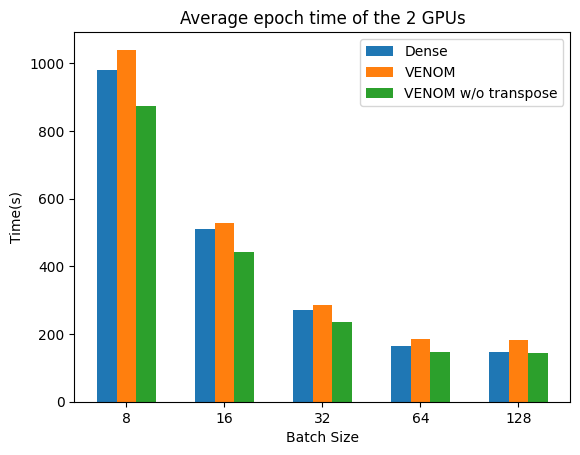

In [205]:
# Draw graph.
width = 0.2  # the width of the bars


fig, ax = plt.subplots()

#ax = df.plot(kind='bar', rot=0, figsize=(20, 6))

ticks_location = np.arange(len(batch_sizes))  # the label locations

# Plotting dense times
dense = ax.bar(ticks_location - width, dense['step_time_mean'], width, label='Dense')

# Plotting venom with transpose stacked
venom_kernels = ax.bar(ticks_location, venom_kernel_time['step_time_mean'], width, label='VENOM kernel time' if split_times else 'VENOM' )
if split_times:
    venom_transpose_time = ax.bar(ticks_location, venom_transpose_time['transpose_time_mean'], width, venom_kernel_time['step_time_mean'], label='VENOM SDDMM transpose time')

# Plotting the fourth and fifth series stacked
venom_no_transpose_kernels = ax.bar(ticks_location + width, venom_no_transpose_kernel_time['step_time_mean'], width, label='VENOM w/o transpose kernel time' if split_times else 'VENOM w/o transpose')
if split_times:
    venom_no_transpose_reshape_time = ax.bar(ticks_location + width, venom_no_transpose_reshape['reshape_time_mean'], width, bottom=venom_no_transpose_kernel_time['step_time_mean'], label='VENOM SDDMM reshape time')


#ax.plot(dense, batch_sizes, color='r', label='Dense kernels')
#dense_bars = ax.bar(tick_location, dense['step_time_mean'], label='Dense kernels')
#dense_bars = ax.bar(tick_location, venom['step_time_mean'], label='VENOM kernels')
#dense_bars = ax.bar(tick_location, venom_no_transpose['step_time_mean'], label='VENOM w/o Transpose kernels')
#ax.plot(venom, batch_sizes, color='g', label='VENOM kernels')
#ax.plot(venom_no_transpose, batch_sizes, color='b', label='VENOM kernels w/o transpose')



# Decorate graph
ax.set_ylabel('Time(s)')
ax.set_xlabel('Batch Size')
ax.set_title('Average epoch time of the '+str(gpus)+' GPUs')
ax.set_xticks(ticks_location)
ax.set_xticklabels(batch_sizes)
ax.legend(loc='upper right')
plt.savefig(figname, bbox_inches='tight')